## Notebook: Generating SLSN Light Curves based on ZTF Raw Data

This notebook shows how to: <br />
1) Load raw ZTF data into the `simsurvey` <br />
2) Feed the SLSN lightcurves generated using the `Magnetar Model` to the transient generator <br />
3) Generate the simulated SLSN light curves which can be detected by the ZTF Survey. <br />
4) Filters the simulated light curves with cutoffs like `|b| > 10` and `sum(rmag < 19.5) >= 3`  <br />
5) Plots the detection phase distribution and the redshift distribution of the SLSNe


In [62]:
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx #
# xxxxxxxxxxxxxxxxxxxxxxx-----------------Generating SLSN Light Curves----------------------xxxxxxxxxxxxxxxxxxxxxxxxx #
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx #

# ------------------------------------------------------------------------------------------------------------------- #
# Import Modules
# ------------------------------------------------------------------------------------------------------------------- #
import os
import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.ticker import MultipleLocator

import sncosmo
import simsurvey
from astropy.time import Time
from astropy import units as u
from astropy.cosmology import Planck15
from astropy.coordinates import SkyCoord

from MagnetarModel import MagnetarSource
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Initialize Globals
# ------------------------------------------------------------------------------------------------------------------- #
gallat_cutoff = 10
mag_band = 'ztfr'
mag_cutoff = 19.5
npoints = 4

dict_bands = {'ztfg': [4087, 4722.7, 5522], 'ztfr': [5600, 6339.6, 7317], 'desi': [7317, 7886.1, 8884]}
dict_rlambda = {'ztfg': 3.694, 'ztfr': 2.425, 'desi': 1.718}

time_start = time.time()
cm = cm.get_cmap('jet')
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Initialize Directories
# ------------------------------------------------------------------------------------------------------------------- #
os.environ["HOME"] = "/data/asingh/simsurvey"
DIR_HOME = os.environ.get("HOME")

# Directory containing the data files
DIR_DATA = "/data/cfremling/simsurvey"
# Directory containing the dust map files of Schlegel, Finkbeiner & Davis (1998)
DIR_SFD = os.path.join(DIR_HOME, "data/sfd98")

# Enter the name of the 'ztf_sim' output file you would like to use.
survey_file = os.path.join(DIR_DATA, "notebooks/df_sim_stats_full.p")
survey_fields = os.path.join(DIR_HOME, "data/ZTF_Fields.txt")
survey_ccds = os.path.join(DIR_HOME, "data/ZTF_corners.txt")
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Load ZTF Fields, CCD Corners and Filters
# ------------------------------------------------------------------------------------------------------------------- #
raw_fields = np.genfromtxt(survey_fields, comments='%')
fields = {'field_id': np.array(raw_fields[:,0], dtype=int), 'ra': raw_fields[:,1], 'dec': raw_fields[:,2]}
fields_df = pd.DataFrame(fields)

ccd_corners = np.genfromtxt(survey_ccds, skip_header=1)
ccds = [ccd_corners[4 * k:4 * k + 4, :2] for k in range(16)]

bands = {'ztfr' : 'data/ztfr_eff.txt', 'ztfg' : 'data/ztfg_eff.txt'}
for band in bands.keys() :
        filename = os.path.join(DIR_HOME, bands[band])
        bpass = np.loadtxt(filename)
        bandname = sncosmo.Bandpass(bpass[:,0], bpass[:,1], name=band)
        sncosmo.registry.register(bandname, force=True)
# ------------------------------------------------------------------------------------------------------------------- #

### Load the ZTF Input Data into the Survey Plan
1) Read the raw ZTF Input Data <br />
2) Modify the data in order to be fed to `simsurvey` <br />
3) Load the modified data into the `SurveyPlan

In [2]:
# ------------------------------------------------------------------------------------------------------------------- #
# Read the Raw ZTF Input Data
# ------------------------------------------------------------------------------------------------------------------- #

def mod_rawdata(inp_df):
    """
    Modify the input Pandas DataFrame to be passed to the SimSurvey.
    Args:
    inp_df   : Input DataFrame to be modified
    Returns:
    out_df   : Output DataFrame with relevant modifications
    """
    band_dict = {1: 'ztfg', 2: 'ztfr', 3: 'desi'}
    survey_start = Time("2018-03-17 00:00:00.000").jd
    survey_end = Time("2019-12-31 00:00:00.000").jd
    
    out_df = inp_df.copy()
    out_df['filterid'] = out_df['filterid'].apply(lambda band: band_dict[band])
    out_df['skynoise'] = [(10 ** (-0.4 * (limmag - 30))) / 5. for limmag in out_df['limMag']]
    out_df = out_df[~out_df['fieldid'].isin([880, 881])]                           # For using only main grid data
    out_df = out_df[out_df['jd'] > survey_start][out_df['jd'] < survey_end]

    print ("Survey pointings for All ZTF Programs: {0}".format(len(out_df)))
    print ("Survey pointings for MSIP Programs: {0}".format(len(out_df[out_df['progid'] == 1])))

    return out_df


raw_df = pd.read_pickle(os.path.join(DIR_DATA, survey_file))
raw_df = mod_rawdata(raw_df)
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Load the Modified ZTF data into the Survey Plan
# ------------------------------------------------------------------------------------------------------------------- #
plan = simsurvey.SurveyPlan(time=raw_df['jd'], band=raw_df['filterid'], obs_field=raw_df['fieldid'], 
                            skynoise=raw_df['skynoise'], obs_ccd=raw_df['chid'], comment=raw_df['progid'],
                            ccds=ccds, fields={k: v for k, v in fields.items()
                                                if k in ['ra', 'dec', 'field_id', 'width', 'height']})

mjd_range = (plan.cadence['time'].min() - 30, plan.cadence['time'].max() + 30)
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Review the pointing schedule, you can use this table
# ------------------------------------------------------------------------------------------------------------------- #
print (type(plan.pointings), len(plan.pointings))
plan.pointings
# ------------------------------------------------------------------------------------------------------------------- #

Survey pointings for All ZTF Programs: 5337921
Survey pointings for MSIP Programs: 5337921
<class 'astropy.table.table.Table'> 5337921


time,band,zp,skynoise,RA,Dec,field,ccd,comment
float64,object,float64,float64,float64,float64,int64,int64,int64
2458197.8162153,ztfr,nan,2801.495928715667,201.71129,18.95,578,0,1
2458197.9025462996,ztfr,nan,1179.2068563255764,224.27392,47.75,759,2,1
2458197.9160069,ztfr,nan,2058.3062636998407,235.44307,33.35,678,49,1
2458198.8676389,ztfr,nan,1930.6786571477928,231.42857,69.35,846,3,1
2458198.8676389,ztfr,nan,1731.8488902949207,231.42857,69.35,846,2,1
2458198.9187153,ztfr,nan,1427.4141435819433,252.57882,18.95,585,19,1
2458198.9187153,ztfr,nan,1349.3045835944579,252.57882,18.95,585,36,1
2458198.9187153,ztfr,nan,1309.5135472284426,252.57882,18.95,585,6,1
2458198.9187153,ztfr,nan,1676.9109308631948,252.57882,18.95,585,60,1


### Input to the Transient Generator
1) It combines a model and a distribution representing the transient population, and randomly draws all the parameters needed to simulate the lightcurves. <br />
2) The maximum redshift has been kept as 0.4, beyond which detectability of SLSN is most likely improbable from ZTF.

In [3]:
# ------------------------------------------------------------------------------------------------------------------- #
# Input the Magnetar Model to the Transient Generator
# ------------------------------------------------------------------------------------------------------------------- #
source = MagnetarSource()
dust = sncosmo.CCM89Dust()
model = sncosmo.Model(source=source, effects=[dust], effect_names=['host'], effect_frames=['rest'])

dict_defaults = {'raw': 1, 'type': 'SLSN', 'template': 1, 'z': (0.01, 0.1), 'data_file': survey_file,
                 'rate': 2.5e-7, 'nmc': 1, 'name': 'output'}

# SLSN_params = {'P': [4.78, 2.93, 2.28, 0.98, 3.5],
#                'B': [2.03e14, 1.23e14, 1.8e13, 0.49e14, 1.56e14],
#                'M_ej': [2.19, 4.54, 6.27, 33.71, 2.75],
#                'v_ej': [5.12, 9.02, 7.01, 8.71, 8.38],
#                'kappa': [0.1, 0.16, 0.16, 0.19, 0.12],
#                'kappa_gamma': [0.06, 0.57, 0.01, 0.01, 0.04],
#                'M_NS': [1.85, 1.83, 1.83, 1.8, 1.8],
#                'T_f': [6.58e3, 8e3, 6.48e3, 6.78, 5.07]}

SLSN_params = {'P': [2.28],
               'B': [1.8e13],
               'M_ej': [6.27],
               'v_ej': [7.01],
               'kappa': [0.16],
               'kappa_gamma': [0.01],
               'M_NS': [1.8],
               'T_f': [6.48e3]}

def random_parameters(redshifts, r_v=2., ebv_rate=0.08, sig_mag=0.5, cosmo=Planck15, **kwargs):
    out = {'distance': np.array(cosmo.luminosity_distance(redshifts).value)}  # To fix the Amplitude
    idx = np.random.randint(0, 1, len(redshifts))  # To fix The Model, 34 for min, 45 for max

    for k, v in SLSN_params.items():
        out[k] = np.array(v)[idx]

    return out

tr = simsurvey.get_transient_generator(zrange=dict_defaults['z'],
                                       ratefunc=lambda z: dict_defaults['rate'],
                                       dec_range=(-31, 90),
                                       mjd_range=(mjd_range[0], mjd_range[1]),
                                       sfd98_dir=DIR_SFD,
                                       transientprop={'lcmodel': model, 'lcsimul_func': random_parameters})
# ------------------------------------------------------------------------------------------------------------------- #


/data/asingh/simsurvey/notebooks/MagnetarModel.py:148: RuntimeWarning: overflow encountered in exp
  y = 2 * self.F_mag(self._E_mag, self._t_mag, t) * np.exp((t / self._t_diff) ** 2) * (t / (self._t_diff ** 2))
/data/asingh/simsurvey/notebooks/MagnetarModel.py:148: RuntimeWarning: overflow encountered in multiply
  y = 2 * self.F_mag(self._E_mag, self._t_mag, t) * np.exp((t / self._t_diff) ** 2) * (t / (self._t_diff ** 2))
/data/asingh/simsurvey/notebooks/MagnetarModel.py:151: RuntimeWarning: invalid value encountered in multiply
  L_out_steps = y_int * np.exp(-(t / self._t_diff) ** 2) * (1 - np.exp(-self._A * (t ** -2)))


### Simulate Survey
Generate light curves using the transient generator and the survey plan as inputs

In [4]:
# ------------------------------------------------------------------------------------------------------------------- #
# Generate The Light Curves
# ------------------------------------------------------------------------------------------------------------------- #
survey = simsurvey.SimulSurvey(generator=tr, plan=plan, )
lcs = survey.get_lightcurves(progress_bar=True, notebook=True)
#, notebook=True # If you get an error because of the progress_bar, delete this line.)
# ------------------------------------------------------------------------------------------------------------------- #

Determining field IDs for all objects


FloatProgress(value=0.0)


Generating lightcurves


FloatProgress(value=0.0)

### Check the Generated Light Curves and Save Them

In [5]:
# ------------------------------------------------------------------------------------------------------------------- #
# Check the Generated Light Curves and Save Them
# ------------------------------------------------------------------------------------------------------------------- #
print (len(lcs.lcs))
print (lcs[0])
lcs.save('LCS_SLSN_MasterV1.pkl')

print("Time Taken to Run the Simulation = {0:.2f} seconds".format(time.time() - time_start))
# ------------------------------------------------------------------------------------------------------------------- #

71
       time        band         flux        ... field ccd comment
------------------ ---- ------------------- ... ----- --- -------
2458505.6349537005 ztfr  -2283.917489382275 ...   565   8       1
   2458505.7372338 ztfg   7307.728359205023 ...   565   8       1
2458507.7584953997 ztfr  -1117.856901201723 ...   565   8       1
2458508.7048494997 ztfg -465.12059248622546 ...   565   8       1
   2458508.7265972 ztfr  3077.2860712082866 ...   565   8       1
2458508.7566782003 ztfr  -6860.645695920093 ...   565   8       1
2458510.7901272997 ztfr -1149.2752245674328 ...   565   8       1
   2458511.6835532 ztfg -312.07922548961153 ...   565   8       1
2458511.6988772997 ztfr  3126.3319738102746 ...   565   8       1
2458514.8796296003 ztfr   17979.41411724077 ...   565   8       1
               ...  ...                 ... ...   ... ...     ...
   2458774.0139468 ztfr  -6278.764359750206 ...   565   8       1
2458779.0157755003 ztfg   6481.742134522667 ...   565   8       1
    245

### Filtering the Simulated Light Curve Data

In [196]:
# ------------------------------------------------------------------------------------------------------------------- #
# Read the Light Curves from the Pickle File
# Filter the Simulated Light Curves Data 
# ------------------------------------------------------------------------------------------------------------------- #

def filter_lcdata(inp_data):
    """
    Filter the Simulated Light Curves data from simsurvey using 
    Args:
    data  : Simulated light curves data
    Returns:
    data  : Filtered light curves data with necessary requirements
    """
    drop_indices = []
    for lc in range(len(inp_data['lcs'])):
        lc_df = pd.DataFrame(data=inp_data['lcs'][lc], columns=inp_data['lcs'][0].dtype.names)
        lc_df['mag'] = -2.5 * np.log10(lc_df['flux']) + lc_df['zp']
        lc_df['phase'] = lc_df['time'] - inp_data['meta']['t0'][lc]
        lc_df['snr'] = lc_df['flux'] / lc_df['fluxerr']

        # Keep the LC points that have an SNR greater than 3
        lc_df = lc_df[lc_df['snr'] >= 3]

        temp_df = lc_df.loc[(lc_df['band'] == mag_band) & (lc_df['mag'] <= mag_cutoff)]

        # Check for LCs that adhere to the Apparent Magnitude cutoff
        if temp_df.shape[0] < npoints:
            drop_indices.append(lc)
            continue

        # Check whether a minimum of 4 detections above the cutoff are separated by atleast 12 hrs.
        else:
            time_diff = np.diff(temp_df['time'].values)
            points_diff = len([val for val in time_diff if abs(val) >= 0.5])
            if points_diff < npoints - 1:
                drop_indices.append(lc)
                continue
                
            # Check whether there are few detections before the maximum or peak <= 18.5 mag
            else:
                maxmag = temp_df['mag'].min()
                ep_max = temp_df[temp_df['mag'] == maxmag].value[0]

                if (temp_df[temp_df['time'] < ep_max].shape[0] < npoints - 1) or (maxmag <= 18.5):
                    drop_indices.append(lc)
                    continue

        # Check for LCs that do not adhere to Galactic Latitude cutoff
        ra, dec = inp_data['meta']['ra'][lc], inp_data['meta']['dec'][lc]
        coord = SkyCoord(ra=ra * u.degree, dec=dec * u.degree, frame='icrs')

        if abs(coord.galactic.b.degree) < gallat_cutoff:
            drop_indices.append(lc)
            
    out_data = inp_data.copy()
    for val in sorted(drop_indices, reverse=True):
        del(out_data['lcs'][val])
    for key in [x for x in out_data.keys() if x in['meta', 'stats']]:
        for val in out_data[key].keys():
            if not val in ['p_binned', 'mag_max']:
                out_data[key][val] = np.delete(out_data[key][val], drop_indices, 0)
            else:
                for subkey in out_data[key][val].keys():
                    out_data[key][val][subkey] = np.delete(out_data[key][val][subkey], drop_indices, 0)

    return out_data

data_raw = pickle.load(open('LCS_SLSN_MasterV1.pkl', 'rb'))
lcs_raw = simsurvey.LightcurveCollection(load='LCS_SLSN_MasterV1.pkl')
print (len(lcs_raw.lcs))

# data = filter_lcdata(data)
pickle.dump(data, open('LCS_SLSN_FilteredV1.pkl', 'wb'))
lcs = simsurvey.LightcurveCollection(load='LCS_SLSN_FilteredV1.pkl')
print (len(lcs.lcs))
# ------------------------------------------------------------------------------------------------------------------- #


71
71


In [197]:
# print (data['stats']['mag_max'])
print (len(data['lcs']), len(data['meta']['t0']))
# print (data['stats']['p_det'])
# print (data['stats']['p_last'])
print (len(np.sort(data['stats']['p_last'] - data['stats']['p_det'])))

71 71
71


You can inspect the lightcurves manually. This example should return the lightcurve with the most points with S/N > 5.

/data/lyan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in log10


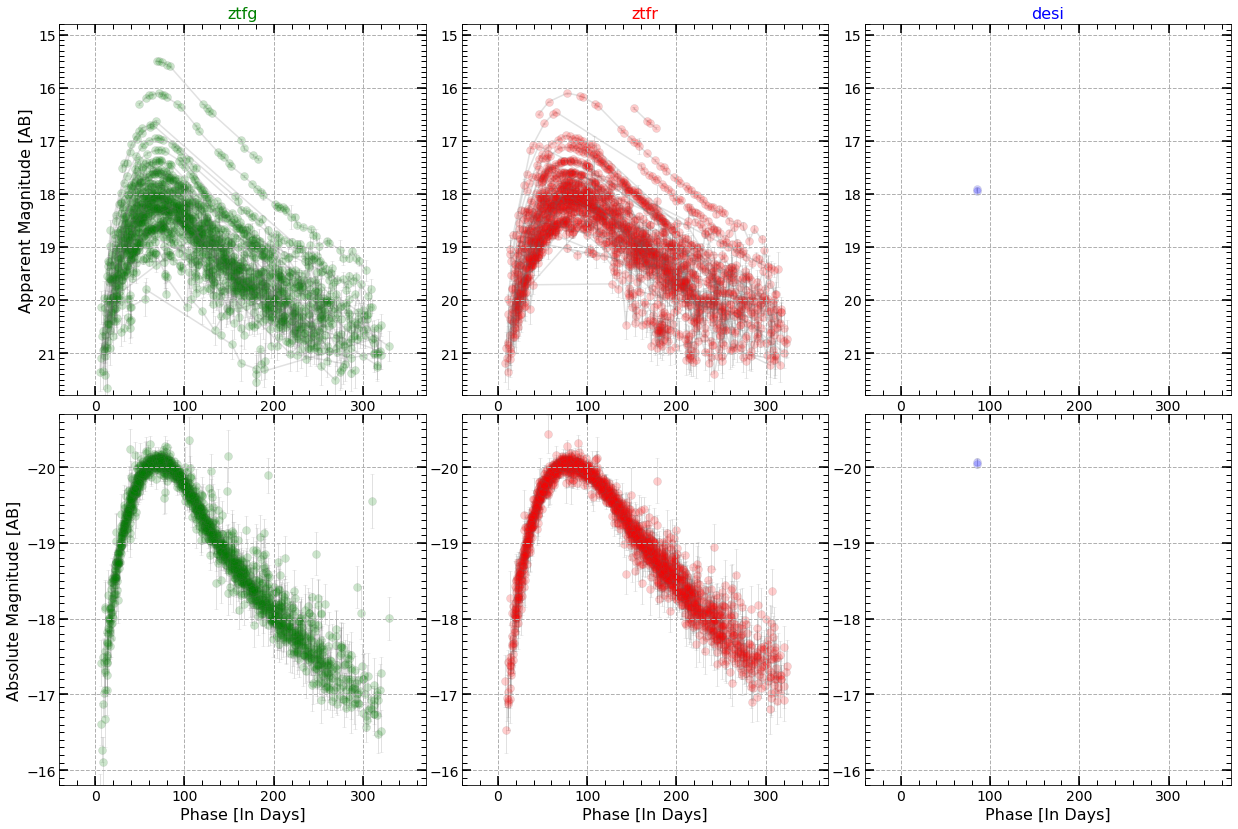

In [201]:
# ------------------------------------------------------------------------------------------------------------------- #
# Plot the Combine Results of the Simulated Light Curves
# ------------------------------------------------------------------------------------------------------------------- #

def set_plotparams(ax_obj, xticks=(100, 20), yticks=(1, 0.1), fs=14):
    """
    Sets plot parameters for plotting Simulated Light Curves.
    """
    ax_obj.grid(True, which='major', ls='--', lw=1)
    ax_obj.xaxis.set_ticks_position('both')
    ax_obj.yaxis.set_ticks_position('both')
    ax_obj.xaxis.set_major_locator(MultipleLocator(xticks[0]))
    ax_obj.xaxis.set_minor_locator(MultipleLocator(xticks[1]))
    ax_obj.yaxis.set_major_locator(MultipleLocator(yticks[0]))
    ax_obj.yaxis.set_minor_locator(MultipleLocator(yticks[1]))
    ax_obj.tick_params(axis='both', which='major', direction='in', width=1.6, length=9, labelsize=fs)
    ax_obj.tick_params(axis='both', which='minor', direction='in', width=1.0, length=5, labelsize=fs)

def set_plotsingle(lc, band, ax_obj1, ax_obj2, corr, data=data):
    """
    Sets plot parameters for plotting individual Simulated Light Curve.
    """
    appmin = df['mag'].max()
    appmax = df['mag'].min()

    ax_obj1.set_ylim(appmin + 0.5, appmax - 0.5)
    ax_obj2.set_ylim(appmin - corr + 0.5, appmax - corr - 0.5)
    
    ep_det = data['stats']['p_det'][lc]
    ep_last = data['stats']['p_last'][lc]
    mag_max = data['stats']['mag_max'][band][lc]

    ax_obj1.axvline(0, ls='-', lw=2, color='k')
    ax_obj2.axvline(0, ls='-', lw=2, color='k')
    ax_obj1.axvline(ep_det, ls='-', lw=2, color='navy')
    ax_obj2.axvline(ep_det, ls='-', lw=2, color='navy')
    ax_obj1.axvline(ep_last, ls='-', lw=2, color='navy')
    ax_obj2.axvline(ep_last, ls='-', lw=2, color='navy')
    ax_obj1.axhline(appmax, ls='-', lw=2, color='k')
    ax_obj2.axhline(appmax - corr, ls='-', lw=2, color='k')
    
    ax_obj1.text(-11, appmax + 0.5, 'Explosion Epoch', fontsize=10, rotation=90)
    ax_obj2.text(-11, appmax - corr + 0.5, 'Explosion Epoch', fontsize=10, rotation=90)
    ax_obj1.text(ep_det - 11, appmax + 0.5, 'Detection Epoch', fontsize=10, rotation=90)
    ax_obj2.text(ep_det - 11, appmax - corr + 0.5, 'Detection Epoch', fontsize=10, rotation=90)
    ax_obj1.text(ep_last - 11, appmax + 0.5, 'Last Epoch', fontsize=10, rotation=90)
    ax_obj2.text(ep_last - 11, appmax - corr + 0.5, 'Last Epoch', fontsize=10, rotation=90)
    ax_obj1.text(100, appmax - 0.05, 'Maximum Magnitude', fontsize=10)
    ax_obj2.text(100, appmax - corr - 0.05, 'Maximum Magnitude', fontsize=10)
    

def plot_lcs(ax, df, lc, band, data=data, alpha=0.5, single=False):
    """
    Plots the Simulated Light Curves in a 2 x 3 Grid with 2 rows depicting the Apparent 
    and the Absolute Light Curves, respectively whereas the 3 columns depict the different 
    ZTF filters.
    """
    if band == 'ztfg':
        index = 0
        color = 'g'
    elif band == 'ztfr':
        index = 1
        color = 'r'
    elif band == 'desi':
        index =  2
        color = 'blue'

    ax_obj1 = ax[0][index]
    ax_obj2 = ax[1][index]

    zlc = data['meta']['z'][lc]
    distlc = Planck15.luminosity_distance(zlc).value
    distmag = 5 * np.log10(distlc * 1e6) - 5
    corr = distmag + data['meta']['mwebv_sfd98'][lc] * dict_rlambda[band]
        
    ax_obj1.errorbar(df['time'] - data['meta']['t0'][lc], df['mag'], yerr=df['magerr'], ms=8, alpha=alpha,
                    color='dimgrey', markerfacecolor=color, markeredgewidth=0.5, marker='o', ls='-', 
                     capthick=1, elinewidth=1, capsize=2, zorder=1, label='_nolegend_')
    ax_obj2.errorbar(df['time'] - data['meta']['t0'][lc], df['mag'] - corr, yerr=df['magerr'], ms=8, 
                     alpha=alpha, color='dimgrey', marker='o', markerfacecolor=color, markeredgewidth=0.5, 
                     ls='', capthick=1, elinewidth=1, capsize=2, zorder=1, label='_nolegend_')
    
    set_plotparams(ax_obj1)
    set_plotparams(ax_obj2)
    
    if single:
        set_plotsingle(lc, band, ax_obj1, ax_obj2, corr=corr, data=data)
    else:
        ax_obj1.set_ylim(21.8, 14.8)
        ax_obj2.set_ylim(-15.8, -20.7)

    ax_obj1.set_xlim(-40, 370)
    ax_obj2.set_xlim(-40, 370)
    ax_obj1.set_title(band, color=color, fontsize=16)
    ax_obj2.set_xlabel('Phase [In Days]', fontsize=16)
    

fig, ax = plt.subplots(2, 3, figsize=(21, 14))

for lc in range(len(data['lcs'])):
    lc_df = pd.DataFrame(data=data['lcs'][lc], columns=data['lcs'][0].dtype.names)
    lc_df['mag'] = -2.5 * np.log10(lc_df['flux']) + lc_df['zp']
    lc_df['magerr'] = -(2.5 / np.log(10)) * (lc_df['fluxerr'] / lc_df['flux'])
    lc_df['snr'] = lc_df['flux'] / lc_df['fluxerr']
    lc_df = lc_df[lc_df['snr'] >= 3]
    
    for band, df in lc_df.groupby('band'):
        plot_lcs(ax, df, lc, band, alpha=0.2)

# ptf12 = pd.read_csv(template_file, sep='\s+', comment='#')
# ax[0][0].plot(ptf12['Phase'], ptf12['M_g'] + dist_mag, marker='', lw=5, ls='-', color='k', zorder=2, label='PTF12dam')
# ax[0][1].plot(ptf12['Phase'], ptf12['M_r'] + dist_mag, marker='', lw=5, ls='-', color='k', zorder=2, label='PTF12dam')
# ax[0][2].plot(ptf12['Phase'], ptf12['M_i'] + dist_mag, marker='', lw=5, ls='-', color='k', zorder=2, label='PTF12dam')

# ax[1][0].plot(ptf12['Phase'], ptf12['M_g'], marker='', lw=5, ls='-', color='k', zorder=2, label='PTF12dam')
# ax[1][1].plot(ptf12['Phase'], ptf12['M_r'], marker='', lw=5, ls='-', color='k', zorder=2, label='PTF12dam')
# ax[1][2].plot(ptf12['Phase'], ptf12['M_i'], marker='', lw=5, ls='-', color='k', zorder=2, label='PTF12dam')

ax[0][0].set_ylabel('Apparent Magnitude [AB]', fontsize=16)
ax[1][0].set_ylabel('Absolute Magnitude [AB]', fontsize=16)

fig.subplots_adjust(hspace=0.05, wspace=0.10)
fig.savefig('PLOT_LCS_PTF12MagnetarMod.pdf', format='pdf', dpi=2000, bbox_inches='tight')

plt.show()
plt.close(fig)
# ------------------------------------------------------------------------------------------------------------------- #

/data/lyan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  


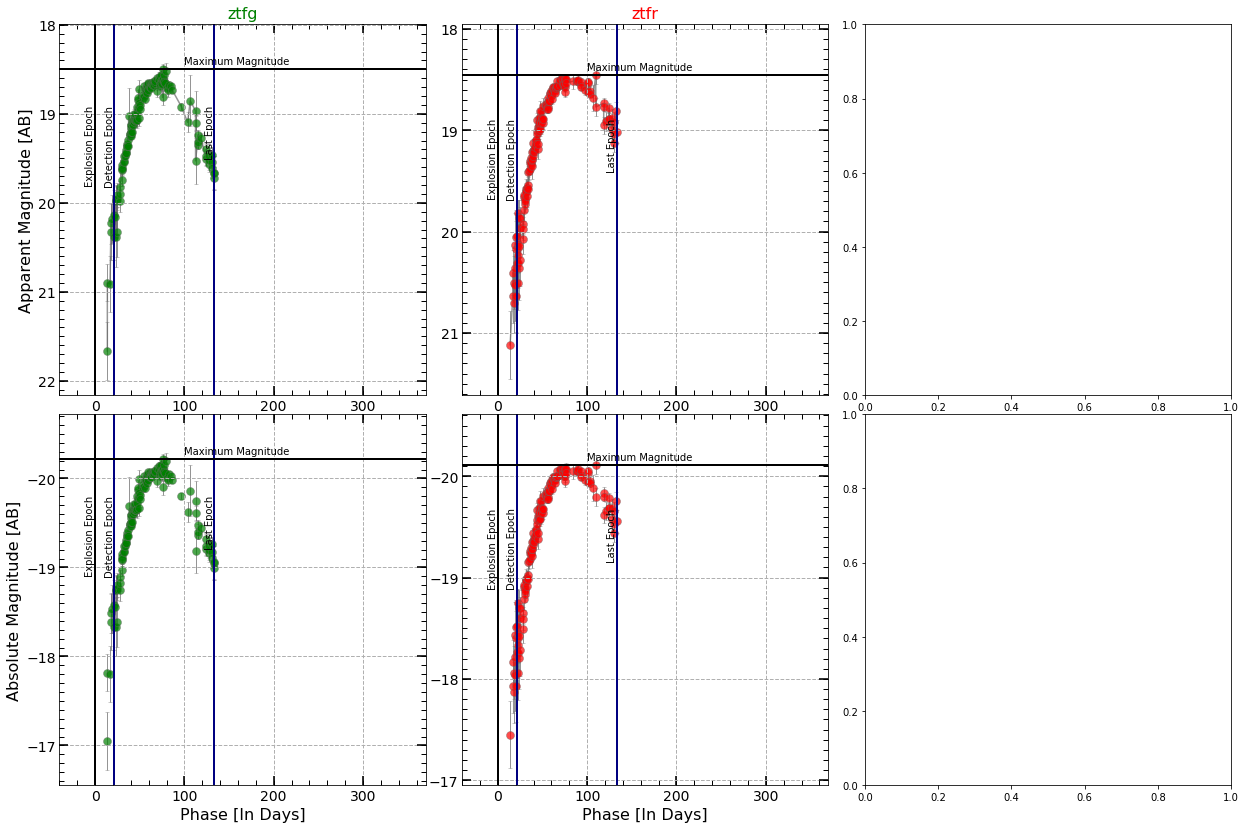

In [202]:
# ------------------------------------------------------------------------------------------------------------------- #
# Plot a single Light Curve from the Simulation (specify Index)
# ------------------------------------------------------------------------------------------------------------------- #
idx = 2
fig2, ax2 = plt.subplots(2, 3, figsize=(21, 14))

lc_df = pd.DataFrame(data=data['lcs'][idx], columns=data['lcs'][idx].dtype.names)
lc_df['mag'] = -2.5 * np.log10(lc_df['flux']) + lc_df['zp']
lc_df['magerr'] = -(2.5 / np.log(10)) * (lc_df['fluxerr'] / lc_df['flux'])
lc_df['snr'] = lc_df['flux'] / lc_df['fluxerr']
lc_df = lc_df[(lc_df['snr'] >= 3)]

for band, df in lc_df.groupby('band'):
    plot_lcs(ax2, df, idx, band, alpha=0.7, single=True)

ax2[0][0].set_ylabel('Apparent Magnitude [AB]', fontsize=16)
ax2[1][0].set_ylabel('Absolute Magnitude [AB]', fontsize=16)

fig2.subplots_adjust(hspace=0.05, wspace=0.10)
fig2.savefig('PLOT_OutputLC_{0}.pdf'.format(idx), format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig2)
# ------------------------------------------------------------------------------------------------------------------- #

### Detection Phase Distribution

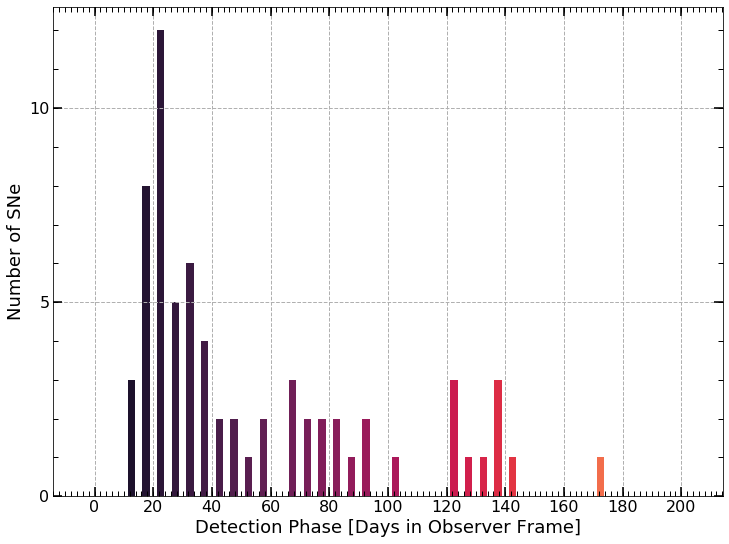

In [179]:
fig1 = plt.figure(figsize=(12, 9))
ax1 = fig1.add_subplot(111)

heights, bins = np.histogram(lcs.stats['p_det'], range=(-5, 205), bins=42)
centers = (bins[:-1] + bins[1:]) / 2

ax1.bar(centers, heights, width=2.5, color=sns.color_palette('rocket', int(len(bins) * 1.2)))
# ax1.hist(lcs.stats['p_det'], histtype='bar', rwidth=0.75, color='dimgrey', range=(-10, 120), bins=32)

ax1.grid(True, which='major', ls='--', lw=1)
ax1.xaxis.set_ticks_position('both')
ax1.yaxis.set_ticks_position('both')
ax1.yaxis.set_major_locator(MultipleLocator(5))
ax1.yaxis.set_minor_locator(MultipleLocator(1))
ax1.xaxis.set_major_locator(MultipleLocator(20))
ax1.xaxis.set_minor_locator(MultipleLocator(2))
ax1.tick_params(axis='both', which='major', direction='in', width=1.6, length=9, labelsize=16)
ax1.tick_params(axis='both', which='minor', direction='in', width=1.0, length=5, labelsize=16)

ax1.set_xlabel('Detection Phase [Days in Observer Frame]', fontsize=18)
ax1.set_ylabel('Number of SNe', fontsize=18)

fig1.savefig('PLOT_SLSNDetectionPhaseDistribution.pdf', format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig1)

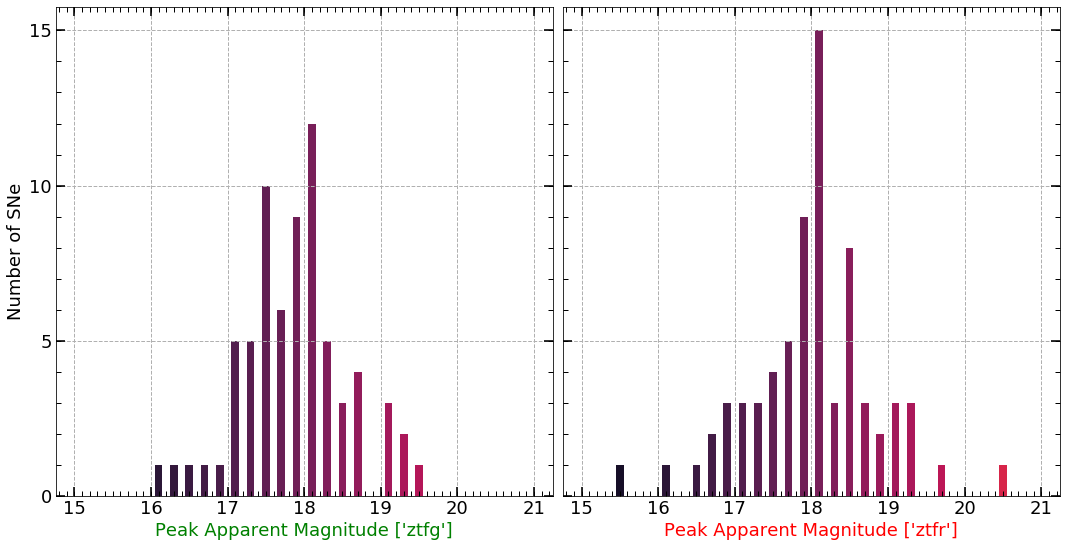

In [192]:
# fig5 = plt.figure(figsize=(12, 9))
# ax5 = fig5.add_subplot(111)

fig5, (ax51, ax52) = plt.subplots(1, 2, sharey=True, figsize=(18, 9))
h_g, bins_g = np.histogram(lcs.stats['mag_max']['ztfg'], range=(15, 21), bins=30)
h_r, bins_r = np.histogram(lcs.stats['mag_max']['ztfr'], range=(15, 21), bins=30)
cen_g = (bins_g[:-1] + bins_g[1:]) / 2
cen_r = (bins_r[:-1] + bins_r[1:]) / 2

ax51.bar(cen_g, h_r, width=0.1, color=sns.color_palette('rocket', int(len(bins) * 1.2)))
ax52.bar(cen_r, h_g, width=0.1, color=sns.color_palette('rocket', int(len(bins) * 1.2)))

set_plotparams(ax51, xticks=(1, 0.1), yticks=(5, 1), fs=18)
set_plotparams(ax52, xticks=(1, 0.1), yticks=(5, 1), fs=18)

ax51.set_xlabel("Peak Apparent Magnitude ['ztfg']", color='g', fontsize=18)
ax52.set_xlabel("Peak Apparent Magnitude ['ztfr']", color='r', fontsize=18)
ax51.set_ylabel('Number of SNe', fontsize=18)

fig5.subplots_adjust(wspace=0.02)
fig5.savefig('PLOT_SLSNAppMagDistribution.pdf', format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig5)

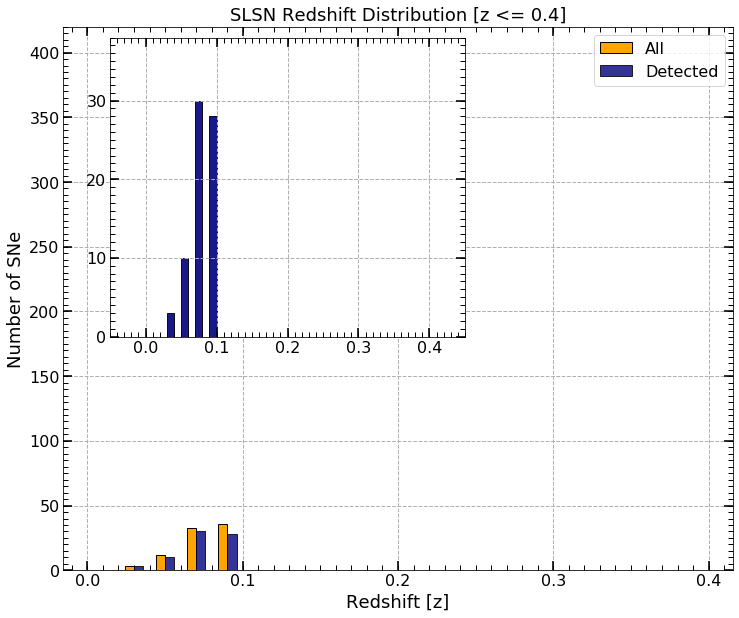

In [11]:
fig2 = plt.figure(figsize=(12, 10))
ax2 = fig2.add_subplot(111)

zhsfull, zbinsfull = np.histogram(lcs.meta_full['z'], range=(0, 0.4), bins=20)
zcentersfull = (zbinsfull[:-1] + zbinsfull[1:]) / 2
zhs, zbins = np.histogram(lcs.meta['z'], range=(0, 0.4), bins=20)
zcenters = (zbins[:-1] + zbins[1:]) / 2

ax2.bar(zcentersfull - 0.003, zhsfull, width=0.006, alpha=1, edgecolor='k', color='orange', label='All')
ax2.bar(zcenters + 0.003, zhs, width=0.006, alpha=0.8, edgecolor='k', color='navy', label='Detected')

# ax2.hist(lcs.meta_full['z'], lw=2, ls='-', histtype='step', color='orangered', range=(0,0.05), bins=25, label='All')
# ax2.hist(lcs.meta['z'], lw=2, ls='-', histtype='step', color='navy', range=(0, 0.05), bins=25, label='Detected')

ax2.set_ylim(0, 420)
ax2.legend(fontsize=16, loc=1)
ax2.grid(True, which='major', ls='--', lw=1)
ax2.xaxis.set_ticks_position('both')
ax2.yaxis.set_ticks_position('both')
ax2.yaxis.set_major_locator(MultipleLocator(50))
ax2.yaxis.set_minor_locator(MultipleLocator(5))
ax2.xaxis.set_major_locator(MultipleLocator(0.1))
ax2.xaxis.set_minor_locator(MultipleLocator(0.01))
ax2.tick_params(axis='both', which='major', direction='in', width=1.6, length=9, labelsize=16)
ax2.tick_params(axis='both', which='minor', direction='in', width=1.0, length=5, labelsize=16)

ax2.set_xticklabels(['' if float(label) < 0 else round(label, 1) for label in ax2.get_xticks()])

ax2.set_xlabel('Redshift [z]', fontsize=18)
ax2.set_ylabel('Number of SNe', fontsize=18)
ax2.set_title('SLSN Redshift Distribution [z <= 0.4]', fontsize=18)

axins = ax2.inset_axes([0.07, 0.43, 0.53, 0.55])
# axins.bar(zcentersfull - 0.005, zhsfull, width=0.01, alpha=0.9, color='orangered', label='All')
axins.bar(zcenters + 0.005, zhs, width=0.01, alpha=0.9, edgecolor='k', color='navy', label='Detected')

axins.set_xlim(-0.05, 0.45)
axins.set_ylim(0, 38)

axins.grid(True, which='major', ls='--', lw=1)
axins.xaxis.set_ticks_position('both')
axins.yaxis.set_ticks_position('both')
axins.yaxis.set_major_locator(MultipleLocator(10))
axins.yaxis.set_minor_locator(MultipleLocator(1))
axins.xaxis.set_major_locator(MultipleLocator(0.1))
axins.xaxis.set_minor_locator(MultipleLocator(0.01))
axins.tick_params(axis='both', which='major', direction='in', width=1.6, length=9, labelsize=16)
axins.tick_params(axis='both', which='minor', direction='in', width=1.0, length=5, labelsize=16)
# ax2.indicate_inset_zoom(axins)

fig2.savefig('PLOT_SLSNRedshiftDistribution.pdf', format='pdf', dpi=2000, bbox_inches='tight')
plt.show()
plt.close(fig2)


In [12]:
# # ------------------------------------------------------------------------------------------------------------------- #
# # Test Code To Find The Faulty ZTF Data
# # ------------------------------------------------------------------------------------------------------------------- #
# raw_df = pd.read_pickle(os.path.join(DIR_DATA, survey_file))
# idx_range = raw_df.index.values
# val_range = np.array_split(idx_range, 1000)

# for val in val_range:
#     try:
#         raw_df = mod_df(pd.read_pickle(os.path.join(DIR_DATA, survey_file)).iloc[val])
#         plan = simsurvey.SurveyPlan(time=raw_df['jd'], band=raw_df['filterid'], obs_field=raw_df['fieldid'], 
#                             skynoise=raw_df['skynoise'], obs_ccd=raw_df['chid'], ccds=ccds, comment=raw_df['progid'], 
#                             fields={k: v for k, v in fields.items() if k in ['ra', 'dec', 'field_id']})
#     except IndexError:
#         print (val)
#         import sys
#         sys.exit(1)
#     else:
#         continue
    
# # ------------------------------------------------------------------------------------------------------------------- #

In [13]:
# raw_df = pd.read_pickle(os.path.join(DIR_DATA, survey_file)).iloc[3906128:3906135]
# raw_df = mod_df(raw_df)
# print (raw_df)
# plan = simsurvey.SurveyPlan(time=raw_df['jd'], band=raw_df['filterid'], obs_field=raw_df['fieldid'], 
#                             skynoise=raw_df['skynoise'], obs_ccd=raw_df['chid'], ccds=ccds, comment=raw_df['progid'], 
#                             fields={k: v for k, v in fields.items() if k in ['ra', 'dec', 'field_id']})

In [ ]:
# def plot_lc(ax, df, lc, band):
#     if band == 'ztfg':
#         index = 0
#         color = 'g'
#     elif band == 'ztfr':
#         index = 1
#         color = 'r'
#     elif band == 'desi':
#         index =  2
#         color = 'orange'

#     ax_obj = ax[lc][index]
#     print (data['meta']['t0'][lc])
#     ax_obj.errorbar(df['time'], df['mag'], yerr=df['magerr'], color=color, 
#                     marker='*', capthick=1, elinewidth=1, capsize=2, label='_nolegend_')

# #     ax_obj.errorbar(df['time'] - data['meta']['t0'][lc], df['mag'], yerr=df['magerr'], color=color, 
# #                     marker='*', capthick=1, elinewidth=1, capsize=2, label='_nolegend_')

#     set_plotparams(ax_obj)
#     ax_obj.set_ylim(23.5, 12.5)
#     ax_obj.set_xlim(-110, 370)
# #     ax_obj.legend(fontsize=16, loc=1)
#     ax_obj.set_title(band, color=color, fontsize=8)
#     ax_obj.set_ylim(df['mag'].max() + 1, df['mag'].min() - 1)
#     ax_obj.set_ylabel('Apparent Magnitude [AB]', fontsize=8)
#     ax_obj.set_xlabel('Phase [In Days]', fontsize=8)


In [ ]:
#             else:
#                 from scipy.interpolate import UnivariateSpline, InterpolatedUnivariateSpline
#                 lc_df['time'] -= lc_df['time'].min()
#                 fit = UnivariateSpline(lc_df['time'], lc_df['flux'], w=lc_df['fluxerr'])
#                 arr = np.arange(lc_df['time'].min(), lc_df['time'].max(), 1)
                
#                 plt.figure(figsize=(9, 9))
#                 plt.scatter(lc_df['time'], lc_df['flux'], marker='*')
#                 plt.plot(arr, fit(arr), ls='--')
#                 plt.ylim(-10000, 10020)
#                 plt.show()